# Detrending Kepler Light Curves

The goal of the detrending is to remove instrument systematics and periodic light curve variability e.g. due to rotation.

- [Long Cadence Detrending](#Long-Cadence-Detrending)
  - [Method and example](#lc_ex)
  - [Full implementation](#lc_all)
  - [Quarter two light curve discontinuity](#Quarter-two-light-curve-discontinuity)
- [Short Cadence Detrending](#Short-Cadence-Detrending)
  - [Method and example](#sc_ex)
  - [Full implementation](#sc_all)

In [1]:
import os
import sys
import ast

import numpy as np

from astropy.table import Table, Column, vstack
import lightkurve

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('../src')
import detrend

## Long Cadence Detrending

### Method and example <a id='lc_ex'></a>

We use the detrending method from [Davenport, 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...829...23D/abstract), whose code was released on [github](https://github.com/jradavenport/appaloosa). We adapted the code to our needs. The following functions in `detrend.py` originate from the Davenport code base (original function names in parentheses):
* `model_lightcurve` (`ModelLC`)
* `irls_spline` (`IRLSSpline`)
* `fit_sine` (`FitSin`)
* `_sinfunc`
* `_sinfunc2`
* `multi_boxcar` (`MultiBoxcar`)

The detrending methodology is as follows:
1. Two-pass multi-boxcar 
  - Rolling median smoothing (minimum Kernal size of 4)
  - Perform sigma clipping (default maximum sigma of 5)
  - Interpolate to fill in rejected points
2. Five-pass fit sine curve
  - Perform a Lomb Scargle periodogram
  - If highest power period has power > some minimum, fit sine curve with that period and subtract from flux
  - Save the sine model as well (sum of 5 sine fits)
3. Three-pass multi-boxcar
4. Twenty-pass Iterative Re-weight Least Squares (IRLS) spline fit
  - Tries scipy's LSQUnivariateSpline first, if that fails falls through to scipy's UnivariateSpline
5. Add sine model to result of step 4 to get the final quiescent flux model

Before detrending is implemented, light curves are split into continuous sections with breaks of no more than 4 hours (8 points).

**Note:** The Optimize warning is normal, and accounted for in the code.

In [11]:
kid = 7349700
quarters = [9,10]

lc_filelist = lightkurve.search_lightcurvefile(f"KIC {kid}", cadence='long', quarter=quarters).download_all()

lc_table_list = []
for lc_file in lc_filelist:

    min_part_num = len(lc_table_list)
    lc_tables = detrend.split_on_gaps(lc_file.SAP_FLUX.to_table(), min_part_num, 1)
    lc_table_list += lc_tables
    
for lc_table in lc_table_list:
    detrend.detrend_longcadence_lc(lc_table)
    
lc_table = vstack(lc_table_list)

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


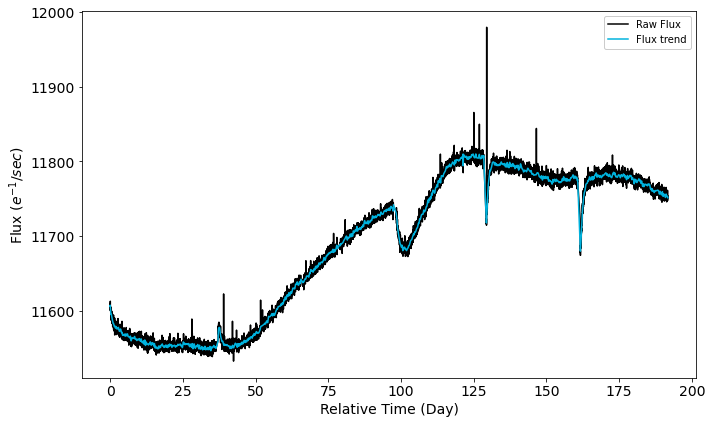

In [12]:
f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(lc_table['time'].jd[:18000] - lc_table['time'][0].jd, lc_table['flux'][:18000], 
        c='black', label="Raw Flux")
ax.plot(lc_table['time'].jd[:18000] - lc_table['time'][0].jd, lc_table['flux_model'][:18000], 
        c="#00b2dd", label="Flux trend")
       
ax.set_xlabel("Relative Time (Day)", fontsize=14)
ax.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)
ax.legend(framealpha=1)

plt.tight_layout()
plt.show()

#### Goodness-of-fit tests 

We use 4 different goodness-of-fit tests, all using a 1000 bin histogram of the detrended fluxes:
  
We consider 2 failures a reason to flag a light curve.

Relevent functions:
- `detrend.get_fit_stats`
- `detrend.score_tests`

In [4]:
stats_dict = detrend.get_fit_stats(lc_table)

for elt in stats_dict:
    print(f"{elt}: {stats_dict[elt]}")
    
print(f"\nThe light curve passes the goodness-of-fit tests: {bool(detrend.score_tests(stats_dict))}")

90% width: 0.0012509173837404644
jarque-bera: 20787.972109784696
chisq hist: 37.88942752495241
num peaks: 1

The light curve passes the goodness-of-fit tests: True


### Full Implementation <a id='lc_all'></a>


This code will run through all the long cadence light curves that overlap our GALEX flares:
- Find all light curves associated with overlapping quarters (using LightKurve)
- Download and detrend light curves (using LightKurve)
- Stack detrended light curves together
- Save light curves as ecsv files in 
- Perform goodness-of-fit tests and scoring


The relevant function is:
- `detrend.detrend_and_score` which calls the functions described above.

**Note:** This step will take a significant amount of time to run, how much will depend on your internet speed, as most of the time is in downloading the light curve files.

In [2]:
# Table with the long cadence Kepler quart and GALEX flare crossmatch
lc_crossmatch_table = Table.read("../data_tables/kepler_longcad_crossmatch.ecsv")

In [11]:
lc_info_table = Table.copy(lc_crossmatch_table)
lc_info_table.add_column(Column(name="path", dtype='U256', length=len(lc_info_table)))
lc_info_table.add_column(Column(name="score", dtype=int, length=len(lc_info_table)))

In [15]:
lc_dir = "../light_curves/kepler_lc"
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)

for lc_target in lc_info_table:
    
    # Let's not redo anything already done
    if lc_target["path"]:
        continue
    
    kid = lc_target['KID']
    quarters = ast.literal_eval(lc_target['LC overlap'])
    
    lc_table = detrend.longcad_detrend_and_score(kid, quarters)
    lc_target["score"] = lc_table.meta['score']
    
    path = f"{lc_dir}/kepler_{kid}_lc.ecsv"
    lc_target["path"] = path
    
    lc_table.write(path, format="ascii.ecsv", overwrite=True)  
    
    print('.',end="")  # So we can tell if it hangs

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


.

In [17]:
# Write out the data table
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv")

### Quarter two light curve discontinuity

In quarter two, there is an observable jump in the light curve at MJD 2455079.2, this jump is observed in most quarter 2 light curves although it is of varying sizes, and sometimes a jump up, while somtimes a jump down. Even though there are no data quality flags associated with it, becuase this feature appears on most of the light curves at exactly the same time it seems clear that it is an artifact, so we will go through and remove it. (And then re-detrend the affected light curves.)

In [6]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")

**Example light curve**

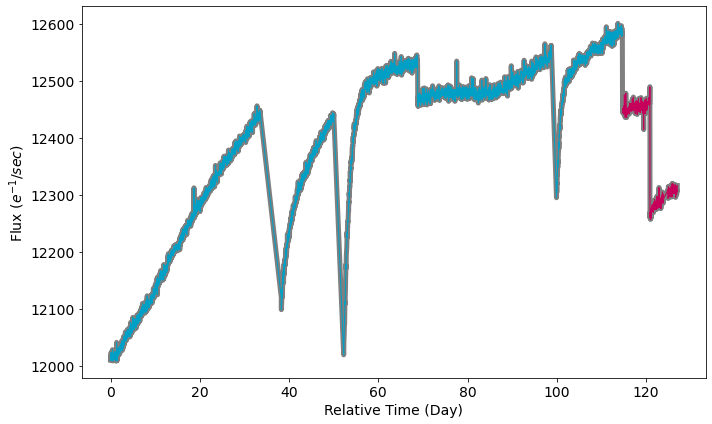

In [20]:
row = lc_info_table[lc_info_table["KID"]==8364667][0]
lc_table = Table.read(row["path"])

f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(lc_table['time'].jd - lc_table['time'][0].jd, lc_table['flux'], 
        c='black', label="Raw Flux", alpha=0.5, lw=5)

ax.plot(lc_table[lc_table["time"].jd<2455079.2]["time"].jd- lc_table['time'][0].jd,
         lc_table[lc_table["time"].jd<2455079.2]["flux"], lw=1, c="#009fc6")
ax.plot(lc_table[lc_table["time"].jd>2455079.2]["time"].jd- lc_table['time'][0].jd,
         lc_table[lc_table["time"].jd>2455079.2]["flux"], lw=1, c="#c6005a")
       
ax.set_xlabel("Relative Time (Day)", fontsize=14)
ax.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)

plt.tight_layout()
plt.show()

**Making this a partition break**

(This will take a few minutes)

In [22]:
for row in lc_info_table:
    
    if not "2" in row['LC overlap']:
        continue
        
    # Add the new partition break
    lc_table = Table.read(row["path"])
    lc_table["partition"][lc_table["time"].jd>2455079.2]+=1
    
    # Redoing detrending
    lc_table_new = detrend.longcad_redetrend_and_score(lc_table)
    
    # recoding the new results
    row["score"] = lc_table_new.meta['score']
    lc_table_new.write(row['path'], format="ascii.ecsv", overwrite=True)


/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/scipy/optim

In [23]:
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv", overwrite=True)

## Short Cadence Detrending

### Method and example <a id='sc_ex'></a>

We use median detrending with a window width that depends on the dominant period of the light curve.

The frequency cuts are as follows:
- $freq < 1~min^{-1}$, window = 401
- $1~min^{-1} \leq freq < 3~min^{-1}$ , window = 201
- $freq \geq 3~min^{-1}$, window = 101


Prior to applying the median detrending we applied sigma clipping (at 5$\sigma$) to avoid having large outliers affect the median.

The relevent functions for this bit are:
- `detrend.determine_window`
- `detrend.detrend_lc`

In [7]:
kid = 2558273
quarter = 4

lc_table = lightkurve.search_lightcurvefile(f"KIC {kid}", cadence='short', quarter=quarter).download_all()[0].SAP_FLUX.to_table()

In [8]:
window,fmax,fap = detrend.determine_window(lc_table)
print(f"Using window: {window}")

detrend.detrend_lc(lc_table,window=window)

Using window: 201


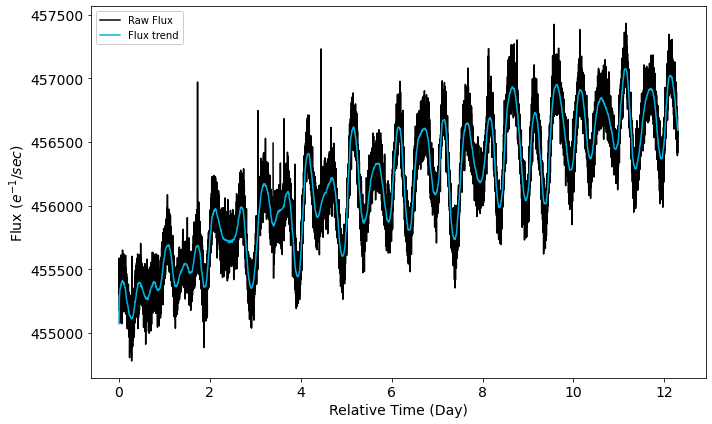

In [9]:
f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(lc_table['time'].jd[:18000] - lc_table['time'][0].jd, lc_table['flux'][:18000], 
        c='black', label="Raw Flux")
ax.plot(lc_table['time'].jd[:18000] - lc_table['time'][0].jd, lc_table['median_trend'][:18000], 
        c="#00b2dd", label="Flux trend")
       
ax.set_xlabel("Relative Time (Day)", fontsize=14)
ax.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)
ax.legend(framealpha=1)

plt.tight_layout()
plt.show()

#### Goodness-of-fit tests 

We use 4 different goodness-of-fit tests, all using a 1000 bin histogram of the detrended fluxes.
  
We consider 2 failures a reason to flag a light curve.

Relevent functions:
- `detrend.get_fit_stats`
- `detrend.score_tests`

In [10]:
stats_dict = detrend.get_fit_stats(lc_table)

for elt in stats_dict:
    print(f"{elt}: {stats_dict[elt]}")
    
print(f"\nThe light curve passes the goodness-of-fit tests: {bool(detrend.score_tests(stats_dict))}")

90% width: 0.0008229899796244593
jarque-bera: 1688.0186508637025
chisq hist: 9902.06096105108
num peaks: 1

The light curve passes the goodness-of-fit tests: True


### Full Implementation <a id='sc_all'></a>


This code will run through all the short cadence targets that overlap our GALEX flaring stars and:
- Find all light curves associated with overlapping quarters (using LightKurve)
- Download and detrend light curves (using LightKurve)
- Stack detrended light curves together
- Save light curves as ecsv files in 
- Perform goodness-of-fit tests and scoring

The relevant function is:
- `detrend.detrend_and_score` 

**Note:** Unfortunately there is only one target with two flares where there is Kepler short cadence data

In [6]:
# Table with the long cadence Kepler quart and GALEX flare crossmatch
sc_crossmatch_table = Table.read("../data_tables/kepler_shortcad_crossmatch.ecsv")

In [7]:
# Set up table to collect info about each target
sc_info_table = Table.copy(sc_crossmatch_table)
sc_info_table.add_column(Column(name="path", dtype='U256', length=len(sc_info_table)))
sc_info_table.add_column(Column(name="window", dtype=int, length=len(sc_info_table)))
sc_info_table.add_column(Column(name="score", dtype=int, length=len(sc_info_table)))

In [8]:
lc_dir = "../light_curves/kepler_sc"
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
    

for sc_target in sc_info_table:
    
    # Let's not redo anything already done
    if sc_target["path"]:
        continue
    
    kid = sc_target['KID']
    quarters = ast.literal_eval(sc_target['SC overlap'])
    
    lc_table = detrend.detrend_and_score(kid, quarters, 5)
    
    sc_target["window"] = lc_table.meta['detrending window']
    sc_target["score"] = lc_table.meta['score']
    
    path = f"{lc_dir}/kepler_{kid}_sc.ecsv"
    sc_target["path"] = path
    
    lc_table.write(path, format="ascii.ecsv")  

In [9]:
# Write out the data table
sc_info_table.write("../data_tables/kepler_shortcad_info.ecsv",format="ascii.ecsv")